In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report

In [3]:
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
X, y = torch.tensor(data.drop(columns='label').values, dtype=torch.float).to('mps'), torch.tensor(data['label'].values, dtype=torch.long).to('mps')

In [5]:
X = X.view(-1, 1, 28, 28)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=1337)

In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.dropout = nn.Dropout(0.2) 
        self.fc1 = nn.Linear(980, 500) 
        self.fc2 = nn.Linear(500, 100)
        self.out = nn.Linear(100, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.pool(x))
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.leaky_relu(self.pool(x))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
 

In [35]:
model = Model()
model.to('mps')
learning_rate = 3e-4

ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


In [36]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
dataloader_train = DataLoader(train_data, batch_size=100, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=100, shuffle=True)

Text(0.5, 1.0, 'Loss Graph')

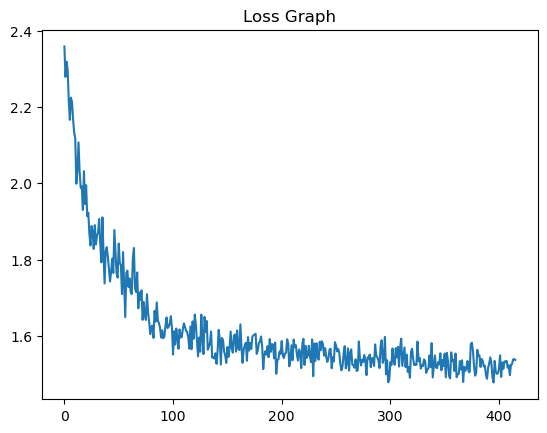

In [37]:
model.train()
epochs = 80

losses = []
for _ in range(epochs):
    for images, labels in dataloader_train:
        preds = model.forward(images)
        loss = ce_loss(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        if _ % 2000 == 0:
            losses.append(loss.item())
        optimizer.step()
 

plt.plot([i for i in range(len(losses))], losses)
plt.title('Loss Graph')

In [ ]:
model.eval()

correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model.forward(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy test: {accuracy:.2f}%')

In [20]:
test_data = pd.read_csv('test.csv')
X = torch.tensor(test_data.values, dtype=torch.float).to('mps')

In [23]:
X = X.view(-1, 1, 28, 28)
num_samples = X.shape[0]

In [26]:
X = TensorDataset(X)

In [27]:
dataloader_test = DataLoader(X, batch_size=100, shuffle=False)


model.eval()

predictions = []
with torch.no_grad():
    for batch in dataloader_test:
        images = batch[0]
        outputs = model.forward(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(predicted)

In [28]:
combined_tensor = torch.cat(predictions, dim=0)
combined_predictions = combined_tensor.tolist()

In [30]:
submission = pd.DataFrame({'ImageId': np.arange(1, len(combined_predictions) + 1), 'Label': combined_predictions})
submission.to_csv('submission.csv', index=False)